In [1]:
%%capture

from lmi import lmi
import time
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm.notebook import tqdm
import torch

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".10"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"
from bmi.estimators import MINEEstimator as MINE
from bmi.estimators import InfoNCEEstimator as InfoNCE

torch.manual_seed(2121)
np.random.seed(2121)

In [2]:
def sample_noisy_circle(N_samples, noise=0.25):

    angle = np.pi * np.random.uniform(0, 2, size=N_samples)
        
    x = np.cos(angle) + np.random.uniform(-noise, noise, size=N_samples)
    y = np.sin(angle) + np.random.uniform(-noise, noise, size=N_samples)

    return x, y

def sample_Gaussian_mixture(N_samples, cov_1=[[1, 0.5], [0.5, 1]], cov_2=[[1, -0.5], [-0.5, 1]]):
    sign = np.random.binomial(1, 0.5, size=N_samples)
    sign = np.tile(sign, (2, 1)).T
    pos = np.random.multivariate_normal([0,0], [[1, 0.9], [0.9, 1]], size=N_samples)
    neg = np.random.multivariate_normal([0,0], [[1, -0.9], [-0.9, 1]], size=N_samples)
    xy = sign*pos + (1-sign)*neg
    x = xy[:, 0]
    y = xy[:, 1]

    return x, y

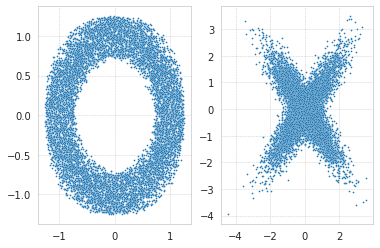

In [3]:
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = (7, 3)
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['legend.fancybox'] = False
rcParams['mathtext.fontset'] = 'stix'


f, axs = plt.subplots(1, 2)
x, y = sample_noisy_circle(10**4)
sns.scatterplot(x=x, y=y, s=3, ax=axs[0])
x, y = sample_Gaussian_mixture(10**4)
sns.scatterplot(x=x, y=y, s=3, ax=axs[1])
plt.show()

In [4]:
d = {
    "Exclusive dimensions" : [],
    "Distribution" : [],
    "Estimate" : [],
    "Estimator" : []
}


N_samples = 2*10**3

for N_nuisance in tqdm(range(0, 10, 2)):

    for trials in range(5):

    
        # circle distribution

        x, y = sample_noisy_circle(N_samples)

        
        X_nuisance = np.random.uniform(0, 1, size=(N_samples, N_nuisance))
        Y_nuisance = np.random.uniform(0, 1, size=(N_samples, N_nuisance))
        
        Xs = np.hstack((x.reshape(-1, 1), X_nuisance))
        Ys = np.hstack((y.reshape(-1, 1), Y_nuisance))

        Xs = np.nan_to_num((Xs - Xs.mean(axis=0)) / Xs.std(axis=0))
        Ys = np.nan_to_num((Ys - Ys.mean(axis=0)) / Ys.std(axis=0))

        true_mi = np.mean(lmi.ksg.mi(Xs[:, 0], Ys[:, 0]))

        d['Exclusive dimensions'].append(N_nuisance)
        d['Distribution'].append("Circle")
        d['Estimate'].append(np.nanmean(lmi.lmi(Xs, Ys)[0]))
        d['Estimator'].append('LMI')

        d['Exclusive dimensions'].append(N_nuisance)
        d['Distribution'].append("Circle")
        d['Estimate'].append(np.nanmean(lmi.lmi(Xs, Ys, regularizer='models.AEMINE', alpha=0.1, lam=10)[0]))
        d['Estimator'].append('LMI-MINE')

        d['Exclusive dimensions'].append(N_nuisance)
        d['Distribution'].append("Circle")
        d['Estimate'].append(np.nanmean(lmi.lmi(Xs, Ys, regularizer='models.AEMINE', alpha=0.1, lam=10)[0]))
        d['Estimator'].append('LMI-InfoNCE')
        
        mine = MINE(verbose=False)
        mine_mi = mine.estimate(Xs, Ys)/np.log(2)

        d['Exclusive dimensions'].append(N_nuisance)
        d['Distribution'].append("Circle")
        d['Estimate'].append(max(0, mine_mi))
        d['Estimator'].append('MINE')

        infonce = InfoNCE(verbose=False)
        infonce_mi = infonce.estimate(Xs, Ys)/np.log(2)

        d['Exclusive dimensions'].append(N_nuisance)
        d['Distribution'].append("Circle")
        d['Estimate'].append(max(0, infonce_mi))
        d['Estimator'].append('InfoNCE')

        d['Exclusive dimensions'].append(N_nuisance)
        d['Distribution'].append("Circle")
        d['Estimate'].append(max(0,np.nanmean(lmi.ksg.mi(Xs, Ys))))
        d['Estimator'].append('KSG')

        # X distribution

        x, y = sample_Gaussian_mixture(N_samples)

        
        X_nuisance = np.random.uniform(0, 1, size=(N_samples, N_nuisance))
        Y_nuisance = np.random.uniform(0, 1, size=(N_samples, N_nuisance))
        
        Xs = np.hstack((x.reshape(-1, 1), X_nuisance))
        Ys = np.hstack((y.reshape(-1, 1), Y_nuisance))

        Xs = np.nan_to_num((Xs - Xs.mean(axis=0)) / Xs.std(axis=0))
        Ys = np.nan_to_num((Ys - Ys.mean(axis=0)) / Ys.std(axis=0))

        true_mi = np.mean(lmi.ksg.mi(Xs[:, 0], Ys[:, 0]))

        d['Exclusive dimensions'].append(N_nuisance)
        d['Distribution'].append("Gaussian mixture")
        d['Estimate'].append(np.nanmean(lmi.lmi(Xs, Ys)[0]))
        d['Estimator'].append('LMI')

        d['Exclusive dimensions'].append(N_nuisance)
        d['Distribution'].append("Gaussian mixture")
        d['Estimate'].append(np.nanmean(lmi.lmi(Xs, Ys, regularizer='models.AEMINE', alpha=0.1, lam=10)[0]))
        d['Estimator'].append('LMI-MINE')

        d['Exclusive dimensions'].append(N_nuisance)
        d['Distribution'].append("Gaussian mixture")
        d['Estimate'].append(np.nanmean(lmi.lmi(Xs, Ys, regularizer='models.AEMINE', alpha=0.1, lam=10)[0]))
        d['Estimator'].append('LMI-InfoNCE')
        
        mine = MINE(verbose=False)
        mine_mi = mine.estimate(Xs, Ys)/np.log(2)

        d['Exclusive dimensions'].append(N_nuisance)
        d['Distribution'].append("Gaussian mixture")
        d['Estimate'].append(max(0, mine_mi))
        d['Estimator'].append('MINE')

        infonce = InfoNCE(verbose=False)
        infonce_mi = infonce.estimate(Xs, Ys)/np.log(2)

        d['Exclusive dimensions'].append(N_nuisance)
        d['Distribution'].append("Gaussian mixture")
        d['Estimate'].append(max(0, infonce_mi))
        d['Estimator'].append('InfoNCE')

        d['Exclusive dimensions'].append(N_nuisance)
        d['Distribution'].append("Gaussian mixture")
        d['Estimate'].append(max(0,np.nanmean(lmi.ksg.mi(Xs, Ys))))
        d['Estimator'].append('KSG')

  0%|          | 0/5 [00:00<?, ?it/s]

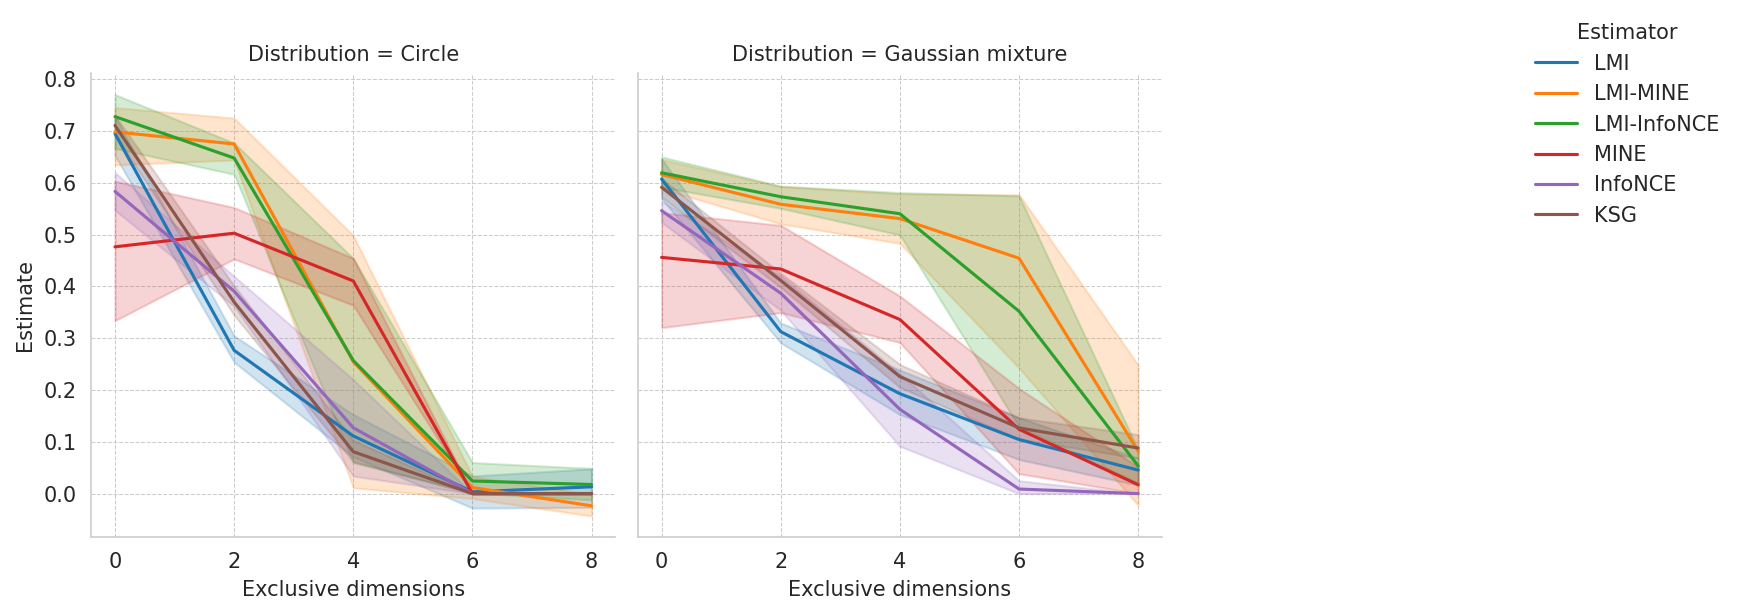

In [10]:
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = (4, 3)
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['legend.fancybox'] = False
rcParams['mathtext.fontset'] = 'stix'

df = pd.DataFrame(d)

ax = sns.relplot(df, x='Exclusive dimensions', y='Estimate', hue='Estimator', col='Distribution', kind='line', 
                 height=4)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.1, 1.03))